In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Forward problem of GPR

In [2]:
# Define depths to sources and receivers (must be the same)
sources = np.linspace(0.5, 5.5, 6)  # in meters
receivers = sources.copy()
boreholes_distance = 4  # in meters
dh = sources[1] - sources[0]

In [3]:
def GPR_forward(porosity):
    # Transform 4 porosity into 6 porosity layers
    porosity_layers = np.zeros(6)
    porosity_layers[0] = porosity[0]
    porosity_layers[1] = porosity[0]
    porosity_layers[2] = porosity[1]
    porosity_layers[3] = porosity[2]
    porosity_layers[4] = porosity[2]
    porosity_layers[5] = porosity[3]
    # Transform porosity into slowness vector
    slowness = porosity_to_slowness(porosity_layers)
    times = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            if i == j:
                # Fill the diagonal of times matrix
                times[i, i] = slowness[i] * boreholes_distance
            else:
                # Fill no diagonal elements
                height = abs(sources[i] - receivers[j])
                factor = (
                    dh
                    * np.sqrt(1 + boreholes_distance ** 2 / height **2)
                )
                times[i, j] = 0.5 * slowness[i]
                times[i, j] += 0.5 * slowness[j]
                min_index, max_index = min(i, j), max(i, j)
                times[i, j] += sum(slowness[min_index + 1 : max_index])
                times[i, j] *= factor
    return times


def porosity_to_slowness(porosity, kappa_s=5, kappa_w=81):
    c = 0.3  # speed of light in vacumm in m/ns
    porosity = np.array(porosity)
    kappa_sqrt = (1 - porosity) * np.sqrt(kappa_s) + porosity * np.sqrt(kappa_w)
    return kappa_sqrt / c

In [4]:
porosity = [0.2, 0.2, 0.4, 0.2]
times = GPR_forward(porosity)

# Inverse problem with rejection sampling

In [6]:
def likelihood(times, porosity, sigma):
    n_times = times.size
    difference = (
        GPR_forward(porosity).ravel()
        - times.ravel()
    )
    difference_sq = difference.sum() ** 2
    likelihood = (
        (1 / np.sqrt(2 * np.pi) / sigma) ** 36
        * np.exp(-0.5 * difference_sq / sigma ** 2)
    )
    return likelihood

In [10]:
# Define sigma
sigma = 1  # in ns
# Define supremum
supremum = (1 / np.sqrt(2 * np.pi) / sigma) ** 36 * np.exp(- 0.5 * 36)
supremum = 4e-15


iterations = 100000
porosities = np.zeros((iterations, 4))
n_accepted = 0
likes = np.zeros(iterations)
for i in range(iterations):
    # Draw a porosity array with uniform distribution between 0.2 and 0.4
    porosity_prop = (0.4 - 0.2) * np.random.rand(4) + 0.2
    # Check if it should be rejected or accepted
    likes[i] = likelihood(times, porosity_prop, sigma)
    probability = likes[i] / supremum
    if np.random.rand() < probability:
        porosities[n_accepted] = porosity_prop
        n_accepted += 1
        
porosities = porosities[:n_accepted]
print(n_accepted)

744


4e-15


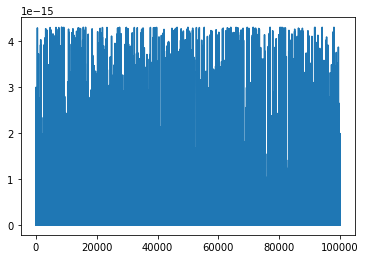

In [11]:
plt.plot(likes)
print(supremum)
plt.show()

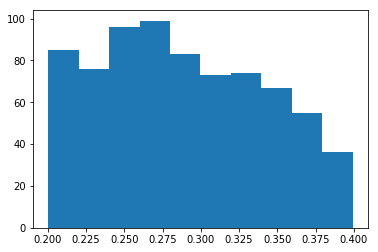

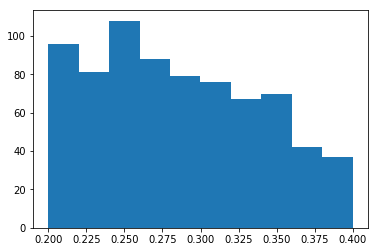

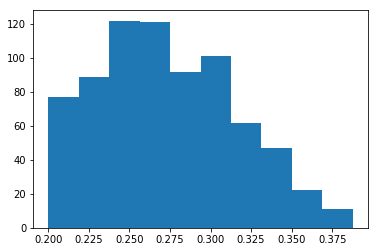

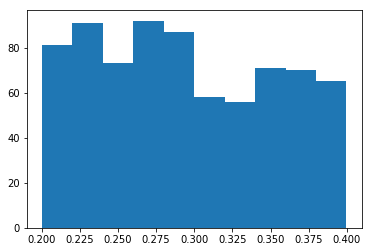

In [12]:
plt.hist(porosities[:, 0])
plt.show()
plt.hist(porosities[:, 1])
plt.show()
plt.hist(porosities[:, 2])
plt.show()
plt.hist(porosities[:, 3])
plt.show()

In [25]:
data = loadmat("data.mat")

In [26]:
times = data["dataobs5"].reshape(6, 6)